In [1]:
import midynet
import numpy as np
import matplotlib.pyplot as plt
import pathlib
import fractions
import json
import pandas as pd
import os
import seaborn as sns

import matplotlib.gridspec as gridspec

from collections import defaultdict
from itertools import product
from matplotlib.lines import Line2D
from midynet.statistics import Statistics
from midynet.utility import display

display.setup_dir("./")

In [2]:
paths_to_figures = ["."]
paths_to_figures = list(map(pathlib.Path, paths_to_figures))
# path_to_data = pathlib.Path("../../../../data/midynet-data/figure4")
path_to_data = pathlib.Path("../../scripts/duality/data/thresholds/")

print(f"{path_to_data=}, exists={path_to_data.exists()}")

path_to_data=PosixPath('../../scripts/duality/data/thresholds'), exists=True


In [56]:
dynamics = ["glauber", "sis", "cowanfw", "cowanbw"]

clabels = dict(sis="infection_prob", glauber="coupling", cowanfw="nu", cowanbw="nu")
dlabels = dict(sis="sis", glauber="glauber", cowanfw="cowan_forward", cowanbw="cowan_backward")
slabels = dict(sis=r"$\chi_{\bar{X}}$", glauber=r"$\chi_M$", cowanfw=None, cowanbw=None)
xlabels = dict(
    sis=r"Transmission rate $\lambda$", 
    glauber=r"Coupling constant $C$", 
    cowanfw=r"Potential gain $\nu$", cowanbw=r"Potential gain $\nu$"
)

ylabels = dict(
    glauber=r"Magnetization $M$",
    sis=r"Average state $\langle \bar{X}\rangle$",
    cowanfw=r"Average state $\langle \bar{X}\rangle$",
    cowanbw=r"Average state $\langle \bar{X}\rangle$",
)
titles = dict(
    glauber="Glauber",
    sis="SIS",
    cowanfw="Cowan",
    cowanbw="Cowan",
)

data = {}
for d in dynamics:
    p = path_to_data / f"threshold-{dlabels[d]}/susceptibility.pkl"
    if p.exists():
        data[d] = next(iter(pd.read_pickle(p).values()))

In [57]:
def get_threshold(df, pname):
    gb = df.groupby(pname).mean()
    idx = gb["susceptibility"].argmax()
    return gb.iloc[idx].name

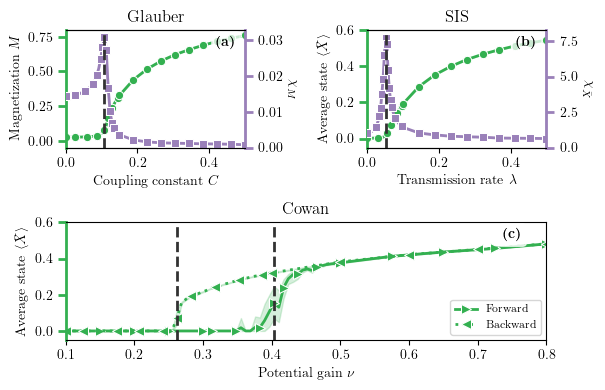

In [58]:
fig = plt.figure(figsize=(6, 4))
spec = gridspec.GridSpec(ncols=2, nrows=2, figure=fig)
ax = np.array([
    fig.add_subplot(spec[0, 0]),
    fig.add_subplot(spec[0, 1]),
    fig.add_subplot(spec[1, :]),
])
acolor = display.med_colors["green"]
scolor = display.med_colors["purple"]
amarker = "o"
smarker = "s"
markersize = 6

lines = {}
for i, d in enumerate(dynamics):
    if i == 3:
        i -= 1
    if d not in data:
        continue
    cl = f"data_model.{clabels[d]}"
    m = amarker
    if d == "cowanfw":
        m = ">"
    elif d == "cowanbw":
        m = "<"
    sns.lineplot(
        data[d], 
        x=cl, 
        y="average", 
        ax=ax[i], 
        color=acolor, 
        marker=m, 
        errorbar=('ci', 99), 
        markevery=0.05,
        markersize=7 if d.startswith("cowan") else markersize,
        linestyle="dotted" if d.endswith("bw") else "-",
        linewidth=2,
        
    )
    lines[d] = ax[i].get_lines()[2 if d == "cowanbw" else 0]
    ax[i].set_xlabel(xlabels[d], fontsize=display.fontsizes["label"])
    ax[i].set_ylabel(ylabels[d], fontsize=display.fontsizes["label"])
    ax[i].set_xlim([0, 0.5])
    ax[i].tick_params(axis="both")
    ax[i].tick_params(axis='y', color=acolor, length=6, width=2)
    ax[i].spines['left'].set_color(acolor)
    ax[i].spines['left'].set_linewidth(2)
    if i < 2:
        axx = ax[i].twinx()
        sns.lineplot(
            data[d], x=cl, y="susceptibility", ax=axx, color=scolor, 
            marker=smarker, errorbar=('ci', 99), markevery=0.05 ,
            markersize=markersize, linewidth=2
        )
        axx.set_ylabel(slabels[d], fontsize=display.fontsizes["label"], rotation=-90, va="bottom")
        thr = get_threshold(data[d], cl)
        axx.axvline(thr, color=display.dark_colors["grey"], linewidth=2, linestyle="--")
        ax[i].set_xlim([0, 0.5])
        axx.tick_params(axis='y', color=scolor, length=6, width=2)
        axx.spines['right'].set_color(scolor)
        axx.spines['right'].set_linewidth(2)
        axx.spines['left'].set_visible(False)
        axx.set_ylim([0., axx.get_ylim()[-1]])
    else:
        ax[i].set_xlim([0.1, 0.8])
        if d == "cowanfw":
#             thr = get_threshold(data[d], cl)
            std = data[d].groupby(cl).std()
            idx = std["average"].argmax()
            thr = std.iloc[idx].name
        else:
            idx = data[d].diff()["average"].argmax() - 1
            thr = data[d][cl][idx]
        
        ax[i].axvline(thr, color=display.dark_colors["grey"], linewidth=2, linestyle="--")
    
    ax[i].set_ylim([-0.05, np.ceil(ax[i].get_ylim()[-1]  * 10) / 10])
        
    if d != "cowanbw":
        display.Label.plot(ax[i], loc="top right")
    ax[i].set_title(titles[d], fontsize=display.fontsizes["large_label"])
        
display.Label.clear()

handles = [
    display.get_label_line("Forward", style=lines["cowanfw"]),
    display.get_label_line("Backward", style=lines["cowanbw"]),
]
ax[2].legend(handles=handles, loc="lower right", fontsize=display.fontsizes["legend"])
    
fig.tight_layout()

for p, fmt in product(paths_to_figures, ["png", "pdf", "svg"]):
    fig.savefig(p / fmt / f"susceptibility.{fmt}")